In [ ]:
#

In [4]:
import numpy as np
import pandas as pd

In [6]:
data = pd.read_csv('marketing_data.csv')

In [3]:
data.head()

,week,tv_spend,search_spend,social_spend,email_spend,sales
0,2023-01-01,21986.856612,7677.428577,5772.571529,2412.708174,3354.851354
1,2023-01-08,19446.942795,8808.101714,10779.097236,2406.754818,2183.361399
2,2023-01-15,22590.754152,11772.371802,5856.335766,2652.739404,3356.900281
3,2023-01-22,26092.119426,8349.155626,6703.348460,2010.501921,2054.432129
4,2023-01-29,19063.386501,8515.100781,6431.002645,2340.976486,3869.505363


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   week          104 non-null    object 
 1   tv_spend      104 non-null    float64
 2   search_spend  104 non-null    float64
 3   social_spend  104 non-null    float64
 4   email_spend   104 non-null    float64
 5   sales         104 non-null    float64
dtypes: float64(5), object(1)
memory usage: 5.0+ KB


In [8]:
data.describe()

,tv_spend,search_spend,social_spend,email_spend,sales
count,104.000000,104.000000,104.000000,104.000000,104.000000
mean,19485.936170,8134.234972,5104.891560,2024.410135,1657.224324
std,3611.292918,1897.485479,1566.952173,451.838801,1127.526331
min,9521.019584,4162.457569,1000.000000,938.052138,-686.075922
25%,17549.760409,6417.214919,4055.112910,1690.582544,875.489765
50%,19189.338271,8359.211671,5100.561578,2011.378504,1536.700033
75%,21460.606093,9193.119315,6052.277816,2312.588120,2405.272188
max,27409.112738,13440.338333,10779.097236,3094.901467,4983.404857


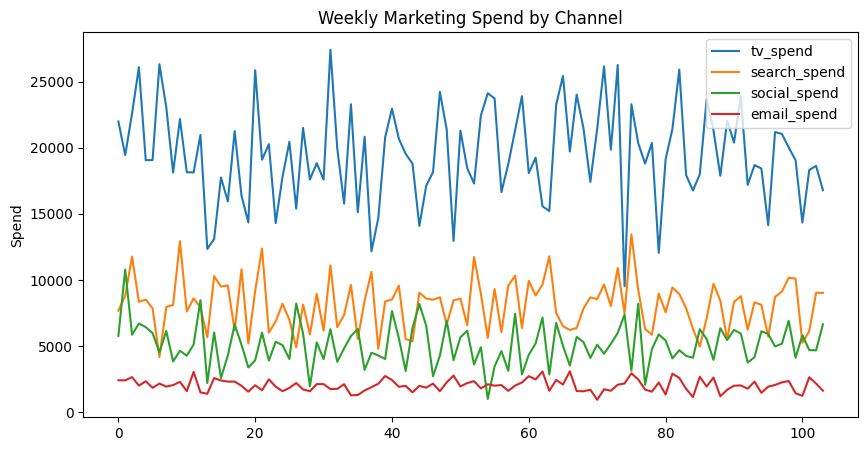

In [9]:
import matplotlib.pyplot as plt

data[["tv_spend", "search_spend", "social_spend", "email_spend"]].plot(
    figsize=(10,5), title="Weekly Marketing Spend by Channel"
)
plt.ylabel("Spend")
plt.show()


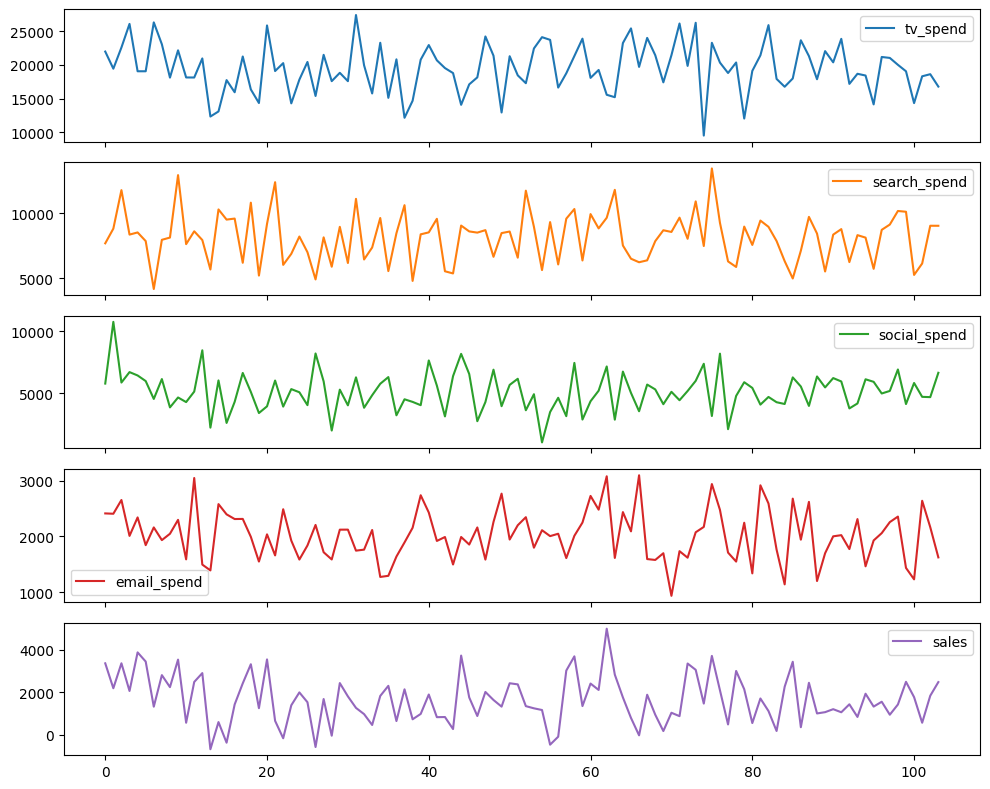

In [10]:


data.drop(columns="week").plot(subplots=True, figsize=(10,8))
plt.tight_layout()


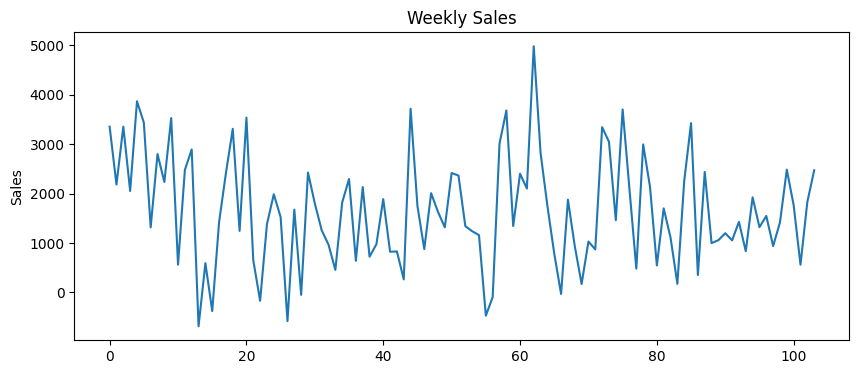

In [11]:
data["sales"].plot(figsize=(10,4), title="Weekly Sales")
plt.ylabel("Sales")
plt.show()


EDA Summary
The dataset contains weekly aggregated marketing spend across four channels and corresponding sales.
No missing values were observed. Spend ranges and sales distribution appear realistic, making the data suitable for regression-based Marketing Mix Modelin

In [12]:
#Regression
from sklearn.linear_model import LinearRegression

X = data[["tv_spend", "search_spend", "social_spend", "email_spend"]]
y = data["sales"]

model = LinearRegression()
model.fit(X, y)

coefficients = pd.DataFrame({
    "channel": X.columns,
    "coefficient": model.coef_
})

coefficients

,channel,coefficient
0,tv_spend,0.007808
1,search_spend,0.194526
2,social_spend,0.219753
3,email_spend,0.188475


In [13]:
baseline_pred = model.predict(X)
baseline_sales = baseline_pred.mean()

baseline_sales

np.float64(1657.224324383758)

In [14]:
scenario = X.copy()

scenario["tv_spend"] *= 0.8

tv_reduction = X["tv_spend"] * 0.2
scenario["social_spend"] += tv_reduction

In [15]:
scenario_pred = model.predict(scenario)
scenario_sales = scenario_pred.mean()

scenario_sales

np.float64(2483.2133270624695)

In [16]:
delta_sales = scenario_sales - baseline_sales
delta_sales

np.float64(825.9890026787116)

In [17]:
##ROI = (Sales contribution) / Spend
roi = coefficients.copy()
roi["avg_spend"] = X.mean().values
roi["roi"] = roi["coefficient"] / roi["avg_spend"]

roi


,channel,coefficient,avg_spend,roi
0,tv_spend,0.007808,19485.936170,4.006810e-07
1,search_spend,0.194526,8134.234972,2.391453e-05
2,social_spend,0.219753,5104.891560,4.304745e-05
3,email_spend,0.188475,2024.410135,9.310123e-05


In [18]:
from optimization import run_optimization


In [19]:
spend_cols = ["tv_spend", "search_spend", "social_spend", "email_spend"]

coeffs = dict(zip(spend_cols, model.coef_))

total_budget = int(X.mean().sum())

bounds = [
    (5000, 20000),   # TV
    (2000, 12000),   # Search
    (1000, 10000),   # Social
    (500, 5000)      # Email
]

initial_guess = list(X.mean().values)


In [20]:
channels, optimized_budget, opt_result = run_optimization(
    coeffs=coeffs,
    total_budget=total_budget,
    bounds=bounds,
    initial_guess=initial_guess
)

channels, optimized_budget


(['tv_spend', 'search_spend', 'social_spend', 'email_spend'],
 array([ 7748.99999992, 12000.        , 10000.        ,  5000.        ]))

In [21]:
comparison = pd.DataFrame({
    "Current_Budget": X.mean().values,
    "Optimized_Budget": optimized_budget
}, index=channels)

comparison


,Current_Budget,Optimized_Budget
tv_spend,19485.936170,7749.0
search_spend,8134.234972,12000.0
social_spend,5104.891560,10000.0
email_spend,2024.410135,5000.0
